# Let's demo LunarLander!

We'll use the solution heuristic for lunar lander as well as a random policy to see how the gravity influences the environment.
First, let's import what we need:

In [1]:
from typing import Union, Optional
import numpy as np

from gymnasium.envs.box2d.lunar_lander import heuristic
import gymnasium.envs.box2d.lunar_lander as lunar_lander
from carl.envs.gymnasium.box2d.carl_lunarlander import CARLLunarLander
from carl.context.context_space import UniformFloatContextFeature
from carl.context.sampler import ContextSampler

/bigwork/nhwpeimt/CARL/carl/envs/__init__.py:28: UserWarning: Module dm_control not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/bigwork/nhwpeimt/CARL/carl/envs/__init__.py:28: UserWarning: Module distance not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(


Then we define our training loop using the heuristic to select the actions:

In [2]:
def run_lunar_lander(
    env: Union[
        CARLLunarLander, lunar_lander.LunarLander, lunar_lander.LunarLanderContinuous
    ],
    seed: Optional[int] = None,
    render: bool = True,
) -> float:
    """
    Copied from LunarLander
    """
    total_reward = 0
    steps = 0

    s, _ = env.reset(
        seed=seed,
    )
    s = s["state"]

    if render:
        env.render()

    while True:
        a = heuristic(env, s)

        s, r, done, truncated, info = env.step(a)
        s = s["state"]

        total_reward += r

        if render and steps % 20 == 0:
            still_open = env.render()

        if done or truncated:  # or steps % 20 == 0:
            # print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("Total reward with heuristic: {:+0.2f}".format(total_reward))
        steps += 1
        if done:
            break
    return total_reward

And here's the random training loop:

In [3]:
def run_lunar_lander_random(
    env: Union[
        CARLLunarLander, lunar_lander.LunarLander, lunar_lander.LunarLanderContinuous
    ],
    seed: Optional[int] = None,
    render: bool = True,
) -> float:
    """
    Copied from LunarLander
    """
    total_reward = 0
    steps = 0

    s, _ = env.reset(
        seed=seed,
    )
    s = s["state"]

    if render:
        env.render()

    while True:
        a = env.action_space.sample()

        s, r, done, truncated, info = env.step(a)
        s = s["state"]

        total_reward += r

        if render and steps % 20 == 0:
            still_open = env.render()

        if done or truncated:  # or steps % 20 == 0:
            # print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            print("Total reward with random policy: {:+0.2f}".format(total_reward))
            print("\n")
        steps += 1
        if done:
            break
    return total_reward

Now we're ready to go! We'll run 5 times with different gravities:

In [9]:
gravities = []
performance_heuristic = []
performance_random = []
for seed in range(5):
    context_distributions = [UniformFloatContextFeature("gravity", upper=12, lower=0.1)]
    context_sampler = ContextSampler(
            context_distributions=context_distributions,
            context_space=CARLLunarLander.get_context_space(),
            seed=seed,
        )
    contexts = context_sampler.sample_contexts(n_contexts=1)
    gravities.append(np.round(contexts[0]['gravity'], decimals=2))
    print(f"Running LunarLander with gravity {np.round(contexts[0]['gravity'], decimals=2)}.")
    env = CARLLunarLander()
    performance_heuristic.append(run_lunar_lander(env, seed=seed, render=True))
    performance_random.append(run_lunar_lander_random(env, seed=seed, render=True))
env.close()

Running LunarLander with gravity 6.63.
Total reward with heuristic: +297.35
Total reward with random policy: -83.35


Running LunarLander with gravity 5.06.
Total reward with heuristic: +260.94
Total reward with random policy: -292.36


Running LunarLander with gravity 5.29.
Total reward with heuristic: +254.62
Total reward with random policy: -90.59


Running LunarLander with gravity 6.65.
Total reward with heuristic: +244.49
Total reward with random policy: -107.54


Running LunarLander with gravity 11.61.
Total reward with heuristic: +265.87
Total reward with random policy: -408.40




Now let's see the result:

Text(0.5, 0, 'Gravity')

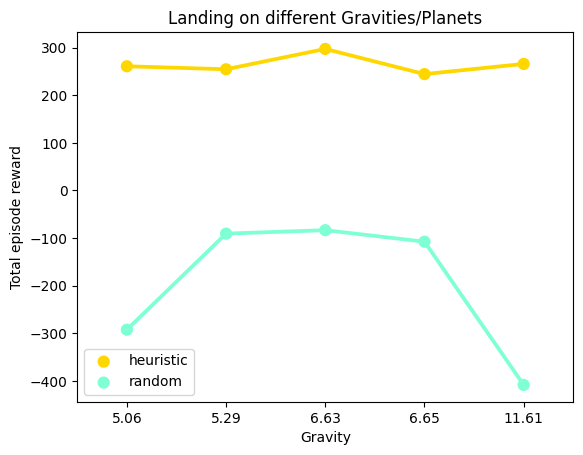

In [19]:
import seaborn as sns
sns.pointplot(x=gravities, y=performance_heuristic, label="heuristic", color="gold")
ax = sns.pointplot(x=gravities, y=performance_random, label="random", color='aquamarine')
ax.legend()
ax.set_title("Landing on different Gravities/Planets")
ax.set_ylabel("Total episode reward")
ax.set_xlabel("Gravity")